In [209]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential

In [7]:

def data_generation(l, name):
    J = 1  # coupling strength
    L = l  # grid size

    temperatures = np.arange(1, 3.51, 0.1)
    ntherm = 100  # thermalization steps
    nsamples = 100  # number of samples for every starting configuration
    nbin = 10  # number of starting configurations

    n = len(temperatures) * nbin * nsamples  # total number of samples

    C = np.empty((n, L, L))
    T = np.empty(n)

    # checkerboard pattern
    x = np.zeros((L, L), dtype=int)
    x[1::2, 0::2] = 1
    x[0::2, 1::2] = 1

    c = 0
    for t in temperatures:
        print(t)
        for i in range(nbin):
            # start with polarized state
            grid = np.ones((L, L)) * (-1)**(i % 2)
            # draw a number of sample configurations
            for j in range(nsamples):
                # perform a number of updates until thermalization
                for k in range(ntherm):
                    neighbors = np.roll(grid, +1, axis=0) + \
                                np.roll(grid, -1, axis=0) + \
                                np.roll(grid, +1, axis=1) + \
                                np.roll(grid, -1, axis=1)
                    # calculate the potential changes in energy
                    dE = 2 * J * (grid * neighbors)
                    # calculate the transition probabilities
                    p = np.exp(-dE / t)
                    # decide which transitions will occur
                    # (avoid updating neighbors using alternating checkerboard pattern)
                    grid *= 1 - 2 * np.multiply(np.int8(np.random.rand(L, L) < p), x ^ (k % 2))

                C[c] = grid
                T[c] = t
                c += 1

    # shuffle and save data
    p = np.random.permutation(len(C))
    
    np.savez_compressed(name, X=C[p], y=T[p])


In [9]:
# data_generation(10, 'data2.npz')
# data_generation( 20, 'data.npz')
# data_generation(30, 'data3.npz')
# data_generation(40, 'data4.npz')

1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000004
1.5000000000000004
1.6000000000000005
1.7000000000000006
1.8000000000000007
1.9000000000000008
2.000000000000001
2.100000000000001
2.200000000000001
2.300000000000001
2.4000000000000012
2.5000000000000013
2.6000000000000014
2.7000000000000015
2.8000000000000016
2.9000000000000017
3.0000000000000018
3.100000000000002
3.200000000000002
3.300000000000002
3.400000000000002
3.500000000000002


In [159]:
def file_loader(file_name):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [160]:
# data -

X_train1, X_test1, y_train1, y_test1, Y_train1, Y_test1 = file_loader('data2.npz')

X_train2, X_test2, y_train2, y_test2, Y_train2, Y_test2 = file_loader('data.npz')

X_train3, X_test3, y_train3, y_test3, Y_train3, Y_test3 = file_loader('data3.npz')

X_train4, X_test4, y_train4, y_test4, Y_train4, Y_test4 = file_loader('data4.npz')

In [98]:
X_test4.shape[0]

3900

In [76]:
l = np.array([[[1,2,-1],[3,4,-2]],[[5,6,-3],[7,8,-4]]])
l.reshape(2,6)

array([[ 1,  2, -1,  3,  4, -2],
       [ 5,  6, -3,  7,  8, -4]])

In [71]:
val = 2000
size = X_train4.shape[1]
X_train3_2d = X_train3.reshape(22100,size*size)
x_t = TSNE(n_components=2).fit_transform(X_train3_2d[:val])

In [80]:

# Generate some dummy data.
# tim = np.load('data3.npz')['y'][:val]
tim = y_train4[:val,0]


# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(tim),vmax=max(tim))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])

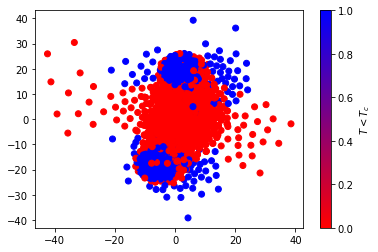

In [82]:
# It shows that the data is separable in higher dimensions
plt.scatter(x_t.T[0], x_t.T[1], c = y_train4[:val,0], cmap = cm1)
plt.colorbar(cpick,label="$T < T_c$")

## Fully Connected Neural Network

In [216]:
def neural(model, X_train, X_test, y_train, y_test):
    
#     print('TRAINING:')
    model.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[1])))
    model.add(keras.layers.Dense(100, activation = 'sigmoid', input_shape=(1024,)))
    model.add(keras.layers.Dense(2, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    model.fit(X_train, y_train, batch_size = 128, epochs = 50, verbose = 0)

    model.evaluate(X_test, y_test, verbose = 1)
    
    return model




In [100]:
model = keras.Sequential()
model = neural(model, X_train2, X_test2, y_train2, y_test2)


TRAINING
Epoch 1/50
173/173 [==============================] - 5s 3ms/step - loss: 0.6901 - accuracy: 0.5662
Epoch 2/50
173/173 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.7429
Epoch 3/50
173/173 [==============================] - 0s 3ms/step - loss: 0.5263 - accuracy: 0.8875
Epoch 4/50
173/173 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.9367
Epoch 5/50
173/173 [==============================] - 0s 3ms/step - loss: 0.2538 - accuracy: 0.9488
Epoch 6/50
173/173 [==============================] - 1s 3ms/step - loss: 0.1842 - accuracy: 0.9546
Epoch 7/50
173/173 [==============================] - 0s 3ms/step - loss: 0.1493 - accuracy: 0.9583
Epoch 8/50
173/173 [==============================] - 1s 3ms/step - loss: 0.1272 - accuracy: 0.9606
Epoch 9/50
173/173 [==============================] - 0s 3ms/step - loss: 0.1124 - accuracy: 0.9647
Epoch 10/50
173/173 [==============================] - 0s 3ms/step - loss: 0.0992 - accurac

In [217]:
print('MODEL1')
model1 = keras.Sequential()
model1 = neural(model1, X_train1, X_test1, y_train1, y_test1)
print('MODEL3')
model3 = keras.Sequential()
model3 = neural(model3, X_train3, X_test3, y_train3, y_test3)
print('MODEL4')
model4 = keras.Sequential()
model4 = neural(model4, X_train4, X_test4, y_train4, y_test4)


MODEL1
122/122 [==============================] - 4s 2ms/step - loss: 0.1936 - accuracy: 0.9279
MODEL3
122/122 [==============================] - 4s 2ms/step - loss: 0.1081 - accuracy: 0.9708
MODEL4
122/122 [==============================] - 4s 2ms/step - loss: 0.1187 - accuracy: 0.9697


Text(0, 0.5, 'Accuracy')

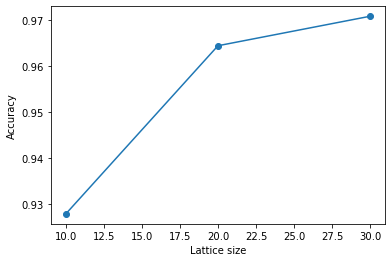

In [272]:
plt.plot([10,20,30], [0.9279,0.9644, 0.9708])
plt.scatter([10,20,30], [0.9279,0.9644, 0.9708])
plt.xlabel('Lattice size')
plt.ylabel('Accuracy')

In [220]:
def preds(model, X_test, size):
    l = []

#     print('PREDICTIONS:')
    for i in range(1,size):
#         print('i=',i)
        l.append(model.predict(X_test[(i-1):(i)], verbose = 0))
    l = np.array(l)
    
    return l

In [201]:
def sortIt(l, y):
    size = l.shape[0]
    a = np.zeros(size)
    b = np.zeros(size)
    l1 = np.zeros(size)
    l2 = np.zeros(size)
    for x in range(size):
      a[x]=l[x][0][0]
      b[x]=l[x][0][1]
      l1[x]=y[x]

    c = np.array([l1, a])
    sorted_c = c.T[l1.argsort()]
    
    d = np.array([l1, b])
    sorted_d = d.T[l1.argsort()]
    
    return sorted_c, sorted_d

In [203]:
def plotIt(sorted, y_test, yes=True):
    
    t = np.arange(1, 3.51, 0.1)
    vals = np.zeros(t.shape[0])
    x_axisc = sorted[:,0]
    y_axis = sorted[:,1]
    k2=0
    
    for i in t:
        val=0
        count=0
        flag=0
        k=0
        for j in x_axis:
            if(i==j):
                val=val+y_axis[k]
                count=count+1
                flag=1
            k=k+1
        if(flag==1):
            vals[k2] = val/count
        if(flag==0 and k2!=0):
            vals[k2] = vals[k2-1]
        k2+=1

    plt.plot(t, vals)
    
#     if(yes):
#         first_line = LineString(np.column_stack((t, vals)))
#         return first_line
#     else:
#         second_line = LineString(np.column_stack((t, vals)))
#         return second_line

In [229]:
l1 = preds(model1, X_test1, size)

In [230]:
# l = preds(model, X_test2, size)


In [231]:
l3 = preds(model3, X_test3, size)


In [233]:
# l4 = preds(model3, X_test4, size)

In [234]:
def plot_all(model, l, X_test2, y_test2, Y_test2, size = 100):
    
#     l = preds(model, X_test2, size)
    sorted_c, sorted_d = sortIt(l, Y_test2)
    plotIt(sorted_c, y_test2)
    plotIt(sorted_d, y_test2)
    return sorted_c[:,0], sorted_c[:,1], sorted_d[:,0], sorted_d[:,1], val1, val2

Text(0, 0.5, 'Output Layer')

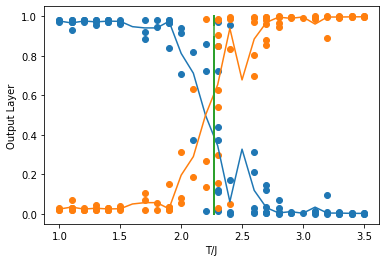

In [270]:
from shapely.geometry import LineString

scx1, scy1, sdx1, sdy1 = plot_all(model1, l1, X_test1, y_test1, Y_test1)
plt.scatter(scx1, scy1)
plt.scatter(sdx1, sdy1)
plt.plot(np.linspace(2.27,2.27,scy3.shape[0]),scy3)
# scx2, scy2, sdx2, sdy2 = plot_all(model3, l, X_test2, y_test2, Y_test2)
# scx3, scy3, sdx3, sdy3 = plot_all(model3, l3, X_test3, y_test3, Y_test3)
plt.xlabel('T/J')
plt.ylabel('Output Layer')



Text(0, 0.5, 'Output Layer')

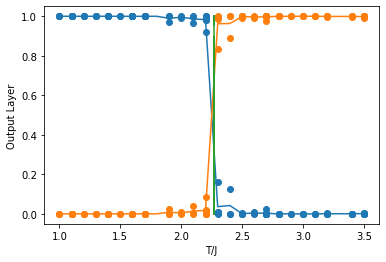

In [259]:
scx2, scy2, sdx2, sdy2 = plot_all(model3, l, X_test2, y_test2, Y_test2)
plt.scatter(scx2, scy2)
plt.scatter(sdx2, sdy2)
plt.plot(np.linspace(2.27,2.27,scy3.shape[0]),scy3)
plt.xlabel('T/J')
plt.ylabel('Output Layer')

Text(0, 0.5, 'Output Layer')

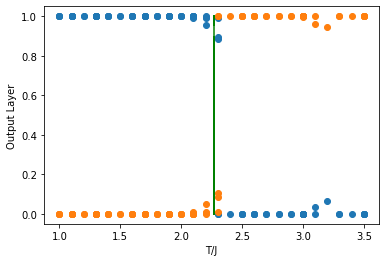

In [261]:
plt.scatter(scx3, scy3)
plt.scatter(sdx3, sdy3)
# plt.scatter(sdx3, sdy3)
plt.plot(np.linspace(2.27,2.27,scy3.shape[0]),scy3, color='g')
plt.xlabel('T/J')
plt.ylabel('Output Layer')

In [262]:
def plotIt2(sorted, y_test, latt):
    
    t = np.arange(1, 3.51, 0.1)
    vals = np.zeros(t.shape[0])
    x_axisc = sorted[:,0]
    y_axis = sorted[:,1]
    k2=0
    
    for i in t:
        val=0
        count=0
        flag=0
        k=0
        for j in x_axis:
            if(i==j):
                val=val+y_axis[k]
                count=count+1
                flag=1
            k=k+1
        if(flag==1):
            vals[k2] = val/count
        if(flag==0 and k2!=0):
            vals[k2] = vals[k2-1]
        k2+=1

    plt.plot(t, (vals-2.27)*(latt))

In [265]:
# plt.scatter(scx1, (scy1-2.27)*(10))
# plt.scatter(sdx1, (sdy1-2.27)*(10))
# sorted_c, sorted_d = sortIt(l, Y_test1)
# plotIt2(sorted_c, y_test1, 10)
# plotIt2(sorted_d, y_test1, 10)
# plt.xlabel('$tL^{1/v}$')
# plt.ylabel('Output Layer')

## CNN

In [212]:
model = Sequential([
          layers.Reshape(target_shape=(40,40,1), input_shape=(40,40)),
          layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
          layers.Flatten(), 
          layers.Dense(128, activation='relu'),
          layers.Dropout(.5),
          layers.Dense(2, activation='softmax')
        ])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

hist = model.fit(X_train4[:1000], y_train4[:1000], epochs=10, batch_size=32, validation_data = (X_test4[:100], y_test4[:100]))


Epoch 1/10
32/32 [==============================] - 16s 369ms/step - loss: 0.5765 - binary_accuracy: 0.9080 - val_loss: 0.0919 - val_binary_accuracy: 0.9700
Epoch 2/10
32/32 [==============================] - 11s 341ms/step - loss: 0.0624 - binary_accuracy: 0.9820 - val_loss: 0.0451 - val_binary_accuracy: 0.9800
Epoch 3/10
32/32 [==============================] - 11s 345ms/step - loss: 0.0301 - binary_accuracy: 0.9930 - val_loss: 0.0032 - val_binary_accuracy: 1.0000
Epoch 4/10
32/32 [==============================] - 11s 338ms/step - loss: 0.0195 - binary_accuracy: 0.9950 - val_loss: 0.0496 - val_binary_accuracy: 0.9900
Epoch 5/10
32/32 [==============================] - 11s 342ms/step - loss: 0.0116 - binary_accuracy: 0.9960 - val_loss: 0.0022 - val_binary_accuracy: 1.0000
Epoch 6/10
32/32 [==============================] - 9s 289ms/step - loss: 0.0056 - binary_accuracy: 0.9980 - val_loss: 0.0131 - val_binary_accuracy: 0.9900
Epoch 7/10
32/32 [==============================] - 9s 288m